# this module will implement a 3D renderer for cubes
# ideally, code this so that it is not that hard to make it in verilog

In [8]:
from IPython.display import display 
from PIL import Image

In [9]:
# definitions
# these are defined beforehand
# the e will be dynamic in the future (it is the head position)
# note that vectors must be in float format

float_1 = float(1) # 32'b00111111100000000000000000000000

u = (float_1, 0, 0)
v = (0, float_1, 0)
e = (1800, 1800, -300) # put it farther away from the plane to adjust for distortion, adjust not to be exact so artifacts don't appear
# w = 1024
# h = 768
w = 512
h = 384

w_half = float(w/2)
h_half = float(h/2)

# w = int(1024/4)
# h = int(768/4)

dx = w/2
dy = h/2

# these are sorted by distance
blocks_pos = [(1800, 1800, 700), (1800 + dx, 1800, 800), (1800 - dx, 1800 - dy, 800), (1800 - dx, 1800 + dy, 900), (1800 + dx, 1800 + dy, 901)]
blocks_mat = [(1, 0, 0, 0.7), (0, 0, 1, 0.7), (1, 0, 0, 0.7), (1, 0, 0, 0.2), (0, 0, 1, 0.2)] # ranges from 0 to 1, diffuse RGB and reflection
blocks_dir = [0, 1, 2, 3, 3] #0, 1, 2, 3 -> UP, RIGHT, DOWN, LEFT
lights_pos = [(1400, 1800, 100), (1800, 1800, 100), (2200, 1800, 100)]
lights_intense = [(0.25, 0.5, 0.25), (0.75, 0.5, 0.75), (0.25, 0.5, 0.25)] # colored lights

In [10]:
# import image
img = Image.new("RGB", (w, h))

In [11]:
# display image
def display_image():
    display(img)

In [12]:
# def zero_image():
#     for i in range(img.size[0]):
#         for j in range(img.size[1]):
#             img.putpixel((i, j), (0, 0, 0))

In [13]:
# helper functions

"""

Float functions needed:

add, subtract, multiply, divide
fixed-to-float, float-to-fixed
less than, less than or equal, equal
reciprocal_square_root

"""

# internal float helper functions
def reciprocal_square_root(v):
    v_dot = dot(v, v)
    return 1 / v_dot**0.5

# implement these via modules; specify a valid bit output
def scale(v, c): # 8 cycles for multiplication
    return (v[0] * c, v[1] * c, v[2] * c)
def add(v1, v2): # 11 cycles
    return (v1[0] + v2[0], v1[1] + v2[1], v1[2] + v2[2])
def sub(v1, v2): # 11 cycles
    return (v1[0] - v2[0], v1[1] - v2[1], v1[2] - v2[2])
def dot(v1, v2): # 8 cycles
    return (v1[0] * v2[0]) + (v1[1] * v2[1]) + (v1[2] * v2[2])
def divide(v1, v2): # NEW!!
    return (v1[0] / v2[0], v1[1] / v2[1], v1[2] / v2[2])
def multiply(v1, v2): # NEW!!
    return (v1[0] * v2[0], v1[1] * v2[1], v1[2] * v2[2])
def normalize(v): # 32 cycles
    re_sqrt = reciprocal_square_root(v)
    n = scale(v, re_sqrt)
    return n
def less_than(a, b): # 2 cycles
    return a < b
def vec_less_than(v1, v2): # 2 cycles, NEW!!
    return (v1[0] < v2[0], v1[1] < v2[1], v1[2] < v2[2])
def less_than_equal(a, b): # 2 cycles
    return a <= b
def equals(a, b): # 2 cycles
    return a == b
def vec_comp(v1, v2, comp): # return a vector representing selection from comp
    return (v1[0] if comp[0] else v2[0],
            v1[1] if comp[1] else v2[1],
            v1[2] if comp[2] else v2[2])
def vec_max(v): # return the max vector
    # stage 0
    comp = vec_less_than((v[1], v[1], v[0]), (v[0], v[2], v[2]))
    
    # stage 1
    if comp[1] and comp[2]:
        return v[2]
    elif comp[0]:
        return v[0]
    else:
        return v[1]
def vec_min(v): # return the min vector
    # stage 0
    comp = vec_less_than((v[0], v[2], v[2]), (v[1], v[1], v[0]))
    
    # stage 1
    if comp[1] and comp[2]:
        return v[2]
    elif comp[0]:
        return v[0]
    else:
        return v[1]

In [14]:
def eye_to_pixel(x, y): # tofloat (6), scale (8), add (11), add, sub, normalize (70), add = 117
    # TODO: future, need to incorporate rotation into this algorithm
    # right now, it will follow the player, but it will never rotate
    x_float = float(x)
    y_float = float(y)
    ex_minus_w = float(e[0] - w_half)
    ey_minus_w = float(e[1] - h_half)
    float_100 = float(100)
    proj_plane_top_left = (ex_minus_w, ey_minus_w, float_100) # ints
    scale_u = scale(u, x_float)
    scale_v = scale(v, y_float)
    sum_scales = add(scale_u, scale_v)
    proj_plane_point = add(sum_scales, proj_plane_top_left)
    dir = sub(proj_plane_point, e)
    dir = normalize(dir)
    dir = add(dir, (0.00001, 0.00001, 0.00001)) # assertion: make ray NEVER 0, this is a heu
    return dir

# testing
nums = eye_to_pixel(256, 200)
# print(nums)
# print(float_to_bin(nums))

In [15]:
import bitstring
def float_to_bin(v):
    return (bitstring.BitArray(float=v[0], length=32).bin, bitstring.BitArray(float=v[1], length=32).bin, bitstring.BitArray(float=v[2], length=32).bin)
def float_to_bin_single(val):
    return bitstring.BitArray(float=val, length=32).bin

In [16]:
# assertion: make ray NEVER 0
def does_ray_block_intersect(ray, block_pos, t):    
    # stage 0
    BLOCK_SIZE = float(100)
    block_min = sub(block_pos, (BLOCK_SIZE, BLOCK_SIZE, BLOCK_SIZE))
    block_max = add(block_pos, (BLOCK_SIZE, BLOCK_SIZE, BLOCK_SIZE))

    # stage 1
    min_e = sub(block_min, e)
    max_e = sub(block_max, e)

    # stage 2
    tx1 = divide(min_e, ray) # pipeline ray
    tx2 = divide(max_e, ray)

    # stage 3
    min_tx12_lt = vec_less_than(tx1, tx2)
    max_tx12_lt = vec_less_than(tx2, tx1)

    # stage 4
    tx12_min_select = vec_comp(tx1, tx2, min_tx12_lt)
    tx12_max_select = vec_comp(tx1, tx2, max_tx12_lt)

    # stage 5
    tmin = vec_max(tx12_min_select)
    tmax = vec_min(tx12_max_select)

    # stage 6
    intersects = less_than_equal(tmin, tmax)

    # stage 6.5
    if intersects:
        t[0] = tmin # pipeline this
        return True
    else:
        return False

In [17]:
def get_pixel_color_should_draw_arrow(block_pos, block_dir, scaled_ray):
    should_render_arrow = False
    BLOCK_SIZE = float(100)
    BLOCK_EDGE_SIZE = float(20)
    TWO_BLOCK_SIZE = float(200)
    MINUS_BLOCK_PLUS_EDGE_SIZE = float(-80)
    PLUS_BLOCK_MINUS_EDGE_SIZE = float(80)

    scaled_sub_0 = scaled_ray[2] - block_pos[2]
    scaled_sub_1 = scaled_sub_0 - TWO_BLOCK_SIZE
    scaled_sub_comp = scaled_sub_1 <= 0.01

    # stage 1-0-0
    # need to pipeline block_pos (2 subs, comp) -> 24
    block_pos_normalized = sub(block_pos, (1800, 1800, 0))

    # stage 1-0-1: adds and subs
    # need to pipeline scaled_ray (2 subs, comp, sub) -> 35
    region_a_eq_ray = scaled_ray[1] + scaled_ray[0]
    region_a_eq_block = block_pos_normalized[1] + block_pos_normalized[0]
    region_c_eq_ray = scaled_ray[1] - scaled_ray[0]
    region_c_eq_block = block_pos_normalized[1] - block_pos_normalized[0]
    ud_bounds_0_eq = block_pos_normalized[1] + MINUS_BLOCK_PLUS_EDGE_SIZE
    ud_bounds_1_eq = block_pos_normalized[1] + PLUS_BLOCK_MINUS_EDGE_SIZE
    lr_bounds_0_eq = block_pos_normalized[0] + MINUS_BLOCK_PLUS_EDGE_SIZE
    lr_bounds_1_eq = block_pos_normalized[0] + PLUS_BLOCK_MINUS_EDGE_SIZE
    # stage 1-0-2: comps
    # need to continue to pipeline scaled ray (add/sub) -> 11
    in_region_a = region_a_eq_ray         < region_a_eq_block
    in_region_c = region_c_eq_ray         < region_c_eq_block
    is_in_ud_bounds_0 = ud_bounds_0_eq    < scaled_ray[1]
    is_in_ud_bounds_1 = scaled_ray[1]     < ud_bounds_1_eq
    is_in_lr_bounds_0 = lr_bounds_0_eq    < scaled_ray[0]
    is_in_lr_bounds_1 = scaled_ray[0]     < lr_bounds_1_eq
    x_ray_block_less_than = scaled_ray[0] < block_pos_normalized[0]
    y_ray_block_less_than = scaled_ray[1] < block_pos_normalized[1]

    # stage 1-0-3, this is simply comb logic, we can do it as such to have no delay
    is_in_udlr_bounds = is_in_ud_bounds_0 and is_in_ud_bounds_1 and is_in_lr_bounds_0 and is_in_lr_bounds_1
    in_region_b = not in_region_a
    in_region_d = not in_region_c
    # need to pipeline block_dir (sub, sub, comp, sub, add, comp) -> 48
    if block_dir == 0: # up
        should_render_arrow = y_ray_block_less_than and is_in_udlr_bounds and (not in_region_b and not in_region_d)
    elif block_dir == 1: #right
        should_render_arrow = not x_ray_block_less_than and is_in_udlr_bounds and (not in_region_a and not in_region_d)
        pass
    elif block_dir == 2: #down
        should_render_arrow = not y_ray_block_less_than and is_in_udlr_bounds and (not in_region_a and not in_region_c)
        pass
    elif block_dir == 3: #left
        should_render_arrow = x_ray_block_less_than and is_in_udlr_bounds and (not in_region_b and not in_region_c)
        pass

    # pipeline scaled_sub_comp (sub, add) -> 22
    return scaled_sub_comp and should_render_arrow

"""
add/sub: 11
comp: 2
normalize: 70 (62 + scale) ???
multiply: 8
scale: 8
dot: 19 (mult + add)
max: 3 (2 + 1)
"""
def get_pixel_color(block_pos, block_mat, block_dir, ray, t, print_debug=False):  
    # stage 0
    scaled_ray = scale(ray, t[0])

    # stage 1: can calculate 1-0 and 1-1 at the same time
    # stage 1-0 -> will take (sub, sub, comp, sub, add, comp) -> 49 time to complete
    # need to pipeline block_pos, block_dir by scale -> 8
    should_render_arrow = get_pixel_color_should_draw_arrow(block_pos, block_dir, scaled_ray)

    # ========== stage 1-1 -> will take (add, sub, add, normalize, sub, normalize, dot, multiply, multiply) -> 219 time to complete
    newOrigin = add(e, scaled_ray)

    # stage 2
    # need to pipeline block_pos (scale, add) -> 19
    normal_sub = sub(newOrigin, block_pos)

    # stage 3
    normal_add = add(normal_sub, (0.0001, 0.0001, 0.0001))

    # stage 4
    normal = normalize(normal_add)

    r = [0.0] * len(lights_pos)
    g = [0.0] * len(lights_pos)
    b = [0.0] * len(lights_pos)
    # stage 5
    # this should happen in parallel
    # genvar
    for i in range(len(lights_pos)):
        light_pos = lights_pos[i]
        light_intense = lights_intense[i]
        # stage 5-1
        # should pipeline newOrigin (sub, add, normalize) -> 92
        dist = sub(light_pos, newOrigin)
        
        # stage 5-2
        rayDir = normalize(dist)

        # stage 5-3
        # should pipeline normal (sub, normalize) -> 81
        lambert = dot(rayDir, normal)

        # stage 5-4
        # should pipeline block_mat (scale, add, sub, add, normalize, sub, normalize, dot) -> 211
        light_intense_mat_mult = multiply(light_intense, block_mat)
        lambert_scale = multiply(light_intense_mat_mult, (lambert, lambert, lambert))
        r[i] = lambert_scale[0]
        g[i] = lambert_scale[1]
        b[i] = lambert_scale[2]
    # ========== 

    # stage 6: wait until both 1-0 and 1-1 branches are done. pipeline should_render_arrow by (stage 1-1) -> 219 - (stage 1-0) -> 49 = 170 + (add, add, max) -> 25 = 195 cycles
    # this requires knowing how many lights there are (assume 3)
    r_total_0 = r[0] + r[1]
    g_total_0 = g[0] + g[1]
    b_total_0 = b[0] + b[1]
    # pipeline r[2], g[2], b[2] by 11
    r_total = r_total_0 + r[2]
    g_total = g_total_0 + g[2]
    b_total = b_total_0 + v[2]

    # stage 7
    # check max
    min_rgb = max(r_total, g_total, b_total)
    
    # stage 8
    # pipeline should_render_arrow by 195
    if should_render_arrow:
        return (min_rgb, min_rgb, min_rgb)
    else:
        # pipeline r_total, g_total, b_total by max -> 3
        return [r_total, g_total, b_total]
        
def get_pixel_rgb_formatted(block_pos, block_mat, block_dir, ray, x, y, t, print_debug=False):
    # each instruction is a stage
    rgb = get_pixel_color(block_pos, block_mat, block_dir, ray, t, print_debug=print_debug)
    rgb_lt = vec_less_than(rgb, (1, 1, 1))
    # todo: must pipeline rgb (2)
    rgb_one_low = vec_comp(rgb, (1, 1, 1), rgb_lt)
    rgb_scaled = scale(rgb_one_low, float(255))
    rgb_out = (int(rgb_scaled[0]), int(rgb_scaled[1]), int(rgb_scaled[2]))
    return rgb_out, x, y

In [18]:
# TODO: this is block_selector
def get_intersecting_block(x, y):
    # stage 0
    ray = eye_to_pixel(x, y)

    # stage 1
    t = [[float(1000000000)]] * len(blocks_pos)
    block = [-1] * len(blocks_pos)
    # possibly need to store all values of t, all values of block, then have a mux
    # at the end to find the best block and t combo
    for i in range(len(blocks_pos)):
        if does_ray_block_intersect(ray, blocks_pos[i], t[i]):
            block[i] = i
        else:
            block[i] = -1
    
    # stage 2
    # always comb block
    best_t = -1
    best_block = -1
    for i in range(len(blocks_pos) - 1, -1, -1):
        if block[i] != -1:
            best_t = t[i]
            best_block = block[i]
    
    # todo: pipeline ray
    return ray, best_block, best_t

def render_frame():
    for y in range(h):
        for x in range(w):
            #from block_selector
            ray, block, t = get_intersecting_block(x, y)

            # possibly internal states
            if block == -1:
                rgb = (0, 0, 0)
            else:
                rgb, x, y = get_pixel_rgb_formatted(blocks_pos[block], blocks_mat[block], blocks_dir[block], ray, x, y, t, print_debug=1 if block == 1 else 0)
            
            # put into buffer, and always output from buffer
            img.putpixel((x, y), rgb)

print(get_intersecting_block(0, 0))
print(get_intersecting_block(256, 200))
print(get_intersecting_block(350, 200))

((-0.4997460380435394, -0.3748070285326545, 0.7808788094430302), -1, -1)
((1e-05, 0.02000600119960014, 0.999810059980007), 0, [900.1709784936521])
((0.22873468007995795, 0.019475930219570888, 0.9733065109785444), 1, [1027.4255732601835])


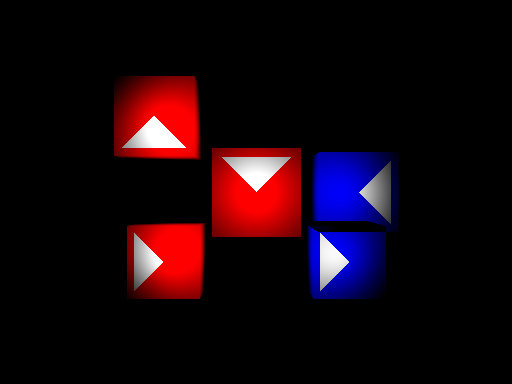

In [19]:
render_frame()
display_image()

In [20]:
do_random = False

if do_random:
    import random
    # blocks_pos = [(1800, 1800, 700)]
    # blocks_mat = [(1, 0, 0, 0.7)]
    # for j in range(random.randint(5, 20)):
    #     if random.randint(0, 1) == 0:
    #         blocks_pos.append((1800 + random.randint(-w, w), 1800 + random.randint(-h, h), blocks_pos[-1][2] + 32))
    #         if random.randint(0, 1) == 0:
    #             blocks_mat.append((1, 0, 0, 1))
    #         else:
    #             blocks_mat.append((0, 0, 1, 1))

    for i in range(10):
        render_frame()
        display_image()
        
        for j in range(len(blocks_pos)):
            # blocks_pos[j] = (blocks_pos[j][0] + random.randint(-16, 16), blocks_pos[j][1] + random.randint(-16, 16), blocks_pos[j][2] - 50)
            blocks_pos[j] = (blocks_pos[j][0] + 0, blocks_pos[j][1] + 0, blocks_pos[j][2] - 50)